### CMPE493 (Introduction to Information Retrieval) | Assignment 2: A Movie Recommendation System
### 2014400072

## Required Libraries

In [1]:
import math
import re
import requests

## Some Parameters and Global Variables

In [2]:
CSV_FILE_PATH = '../movie_ids.csv'  # Path of the CSV files, which stores IMDb movie IDs.

# Regex pattern to extract movie title from HTML source code.
IMDB_TITLE_RGX = r'title_wrapper.+?<h1.*?>(.+?)(?:&nbsp;|<)'

# Regex pattern to extract movie storyline from HTML source code.
IMDB_STORYLINE_RGX = r'<h2>storyline<\/h2>.+?<span>(.+?)<\/span>'

# Regex pattern to extract recommended movies' IMDb IDs from HTML source code.
IMDB_REC_ITEM_RGX = r'rec_item.+?data-tconst="(.+?)"'

# Regex pattern used to replace some punctuation marks in storyline texts with space.
PUNCTUATIONS_RGX = r'(\"|\!|\^|\%|\<|\+|\~|\*|\;|\:|\(|\?|\&|\}|\]|\||\,|\'|\)|\-|\#|\`|\@|\/|\$|\_|\{|\.|\>|\[|\\|\=)'

# Number of highest scored terms that will be considered while calculating cosine similarities. (Will be calculated.)
NUMBER_OF_TERMS_TO_CONSIDER = 0

NUMBER_OF_RECS = 10  # Maximum number of recommended movies to be returned from `recommend(imdb_id)` function.

TERM_DF_DICT = {}  # Maps terms (str) to their document frequencies (int).

MOVIES_DICT = {}   # Maps movie IDs (str) to dict objects ({...}), which store some information about related movie.

`MOVIES_DICT` is a Python Dictionary object in the following structure:

```
{ '<movie-id>': <Movie-Object>, '<movie-id>': <Movie-Object>, ... }
```

`<Movie-Object>` is a Python Dictionary object in the following structure:

```
{ 'title': <A str of movie title>, 'tf': <TF-Object>, 'recs': <A List of recommended (by IMDb) movie IDs (str)> }
```

`<TF-Object>` is a Python Dictionary object in the following structure:
```
{ '<term>': <term frequency>, '<term>': <term frequency>, ... }
```

## IMDb Scraping

In [3]:
def get_movie_contents(imdb_id):
    """
    Gets an IMDb ID and returns its title, storyline, list of IMDb recommendations respectively.
    """
    title, storyline, recs = "", "", []

    rgx_flag = re.IGNORECASE | re.DOTALL

    req = requests.get(f"https://www.imdb.com/title/{imdb_id}")
    if req.status_code == 200:
        imdb_title = re.search(IMDB_TITLE_RGX, req.text, rgx_flag)
        if imdb_title:
            title = imdb_title.group(1).strip()

        imdb_storyline = re.search(IMDB_STORYLINE_RGX, req.text, rgx_flag)
        if imdb_storyline:
            storyline = imdb_storyline.group(1).strip()

        recs = re.findall(IMDB_REC_ITEM_RGX, req.text, rgx_flag)
    else:
        print(f"\n!!! REQUEST TO IMDb SERVER WITH MOVIE ID  '{imdb_id}'  FAILED !!!")

    return title, storyline, recs

## TF-IDF Model

The model used to calculate TF-IDF score (`w`) of a term t in a document d is as follows:

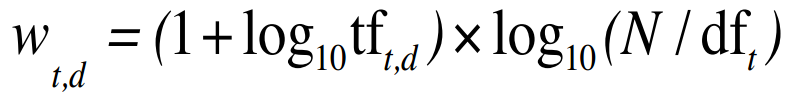

The meanings of `tf`, `df` and `N` are explained in the function docstring below:

In [4]:
def tf_idf_score(tf, df, N):
    """
    Calculates tf-idf score of a term t in a document d.
    :param tf: Frequency of t in d (int, 0 <= tf)
    :param df: Document frequency of t (int, 0 < df <= N)
    :param N: Number of documents (int)
    """
    return 0 if tf == 0 else (1 + math.log10(tf)) * math.log10(N/df)

## Recommendation

In [5]:
def length_of_vec(vec):
    """
    Returns the length of the given vector `vec`.
    """
    return math.sqrt(sum([elem**2 for elem in vec]))


def cosine_similarity(vec1, vec2):
    """
    Returns the cosine similarity of the given vectors `vec1` and `vec2`.
    """
    dot_product = sum([e1*e2 for e1, e2 in list(zip(vec1, vec2))])
    return 0 if dot_product == 0 else dot_product/(length_of_vec(vec1) * length_of_vec(vec2))

In [6]:
def recommend(imdb_id):
    """
    Gets an IMDb ID and returns a list of recommended movie IDs for that movie.
    """
    result = {}  # Maps movie IDs (str) of other movies to their cosine similarities (float) with the requested movie.

    term_scores = {}  # Maps terms of the requested movie (str) to their tf-idf scores (float).

    for (term, freq) in MOVIES_DICT[imdb_id]['tf'].items():
        term_scores[term] = tf_idf_score(freq, TERM_DF_DICT[term], len(MOVIES_DICT))

    # Sorts `term_scores` by tf-idf scores in descending order, and takes highest `NUMBER_OF_TERMS_TO_CONSIDER` terms.
    term_scores = dict(sorted(term_scores.items(), key=lambda x: -x[1])[:NUMBER_OF_TERMS_TO_CONSIDER])

    vec1 = [term_scores[t] for t in term_scores]  # Vector of the requested movie.

    for other_movie_id in MOVIES_DICT:
        if other_movie_id == imdb_id:
            continue

        vec2 = []  # Vector of the other movie.

        for term in term_scores:
            other_movie_term_freq = MOVIES_DICT[other_movie_id]['tf'].get(term, 0)
            other_movie_term_score = tf_idf_score(other_movie_term_freq, TERM_DF_DICT[term], len(MOVIES_DICT))
            vec2.append(other_movie_term_score)

        result[other_movie_id] = round(cosine_similarity(vec1, vec2), 8)

    # Sorts `result` by cosine similarities in descending order, and takes the most similar `NUMBER_OF_RECS` movies.
    result = sorted(result.items(), key=lambda x: -x[1])[:NUMBER_OF_RECS]  # [('<movie-id>', <cosine similarity>), ...]

    return [movie_id for movie_id, _ in result]

## Evaluation

In [7]:
def evaluate_recommendations(rec_movie_ids, relevant_movie_ids, K):
    """
    Gets list of recommended and relevant movie IDs and K value.

    Returns precision, recall, F1 values for K respectively.
    """

    _rec_movie_ids = rec_movie_ids[:K]  # Considers top K recommendations only.

    relevant_recs = set(_rec_movie_ids) & set(relevant_movie_ids)  # Movies that are recommended and relevant.

    precision = len(relevant_recs) / len(_rec_movie_ids)
    recall = len(relevant_recs) / len(relevant_movie_ids)
    
    if precision == 0 and recall == 0:
        f1 = 0
    else:
        f1 = 2 * precision * recall / (precision + recall)

    return precision, recall, f1

## Main Program

This is a helper function which utilizes the functions `recommend()` and `evaluate_recommendations()`.

In [8]:
def process_movie(movie_id):
    """
    Prints recommended movies and the evaluation results for the given `movie_id`.
    """
    recommended_ids = recommend(movie_id)

    print(f"Ranked Recommendations for '{MOVIES_DICT[movie_id]['title']}' ({movie_id})")
    for (i, rec_id) in enumerate(recommended_ids):
        print(f"\t{i+1:02} : {MOVIES_DICT[rec_id]['title']} ({rec_id})")

    print("\nEvaluation Results:")
    for k in (1, 2, 3, 10):
        precision, recall, f1 = evaluate_recommendations(recommended_ids, MOVIES_DICT[movie_id]['recs'], k)
        print(f"K : {k}\t\tPrecision : {precision:.3f}     Recall : {recall:.3f}     F1 : {f1:.3f}")

Here, the program starts collecting data from IMDb with the help of the function `get_movie_contents()` reading the CSV file line by line. During this operation, `MOVIES_DICT` and `TERM_DF_DICT` objects are constructed to be used by `recommend()` and `process_movie()` functions.

In [9]:
# Scrapes movies listed in the CSV file from IMDb, and constructs `MOVIES_DICT` and `TERM_DF_DICT` objects.
with open(CSV_FILE_PATH) as csv_file:
    print("Scraping movies...")

    # Variables used to print progress status.
    counter = 0
    info_line = ""

    for (i, line) in enumerate(csv_file.readlines()):
        movie_id = line.strip()

        counter = (counter + 1) % 4
        info_line += f"\t{i+1:04} : {movie_id}"
        if counter == 0:
            print(info_line)
            info_line = ""

        title, storyline, recs = get_movie_contents(movie_id)

        # 'tf' maps terms (str) of the movie (storyline) to their frequencies (int) in it.
        movie = {'title': title, 'tf': {}, 'recs': recs}

        # Some punctuation marks are removed from the storyline and words are lower-cased.
        tokens = [token.lower() for token in re.sub(PUNCTUATIONS_RGX, " ", storyline).split()]

        for token in tokens:
            if token not in movie['tf']:  # If `token` is encountered for the first time in this movie...
                movie['tf'][token] = 1  # ... assigns a term-frequency of 1 to it.
            else:
                movie['tf'][token] += 1  # Else, increases its term-frequency by 1.

        MOVIES_DICT[movie_id] = movie

        for term in set(tokens):  # unique tokens
            if term not in TERM_DF_DICT:  # If `token` is encountered for the first time in this collection...
                TERM_DF_DICT[term] = 1  # ... assigns a document-frequency of 1 to it.
            else:
                TERM_DF_DICT[term] += 1  # Else, increases its document-frequency by 1.

    print(info_line)
    print(f"Scraping is done.\n")

Scraping movies...
	0001 : tt0112851	0002 : tt2267968	0003 : tt0356634	0004 : tt0363828
	0005 : tt0099088	0006 : tt1877832	0007 : tt0052357	0008 : tt1638002
	0009 : tt0384814	0010 : tt0433722	0011 : tt1504320	0012 : tt0164912
	0013 : tt0057924	0014 : tt1142804	0015 : tt0071276	0016 : tt0158622
	0017 : tt0048641	0018 : tt0059229	0019 : tt0054346	0020 : tt0074147
	0021 : tt0096427	0022 : tt1045658	0023 : tt0050710	0024 : tt2488496
	0025 : tt0119644	0026 : tt0014611	0027 : tt0346314	0028 : tt0377092
	0029 : tt0088050	0030 : tt0060230	0031 : tt2166834	0032 : tt0800320
	0033 : tt0119217	0034 : tt0116705	0035 : tt0070078	0036 : tt0068727
	0037 : tt0093818	0038 : tt0071519	0039 : tt0091327	0040 : tt0435761
	0041 : tt0018773	0042 : tt0076686	0043 : tt0005810	0044 : tt0496634
	0045 : tt0060661	0046 : tt2872750	0047 : tt0038008	0048 : tt1464540
	0049 : tt0007162	0050 : tt0218922	0051 : tt2293640	0052 : tt0145487
	0053 : tt4046784	0054 : tt0393596	0055 : tt4555426	0056 : tt4272866
	0057 : tt12118

	0477 : tt0079944	0478 : tt3783958	0479 : tt0844471	0480 : tt0948470
	0481 : tt0072443	0482 : tt0066183	0483 : tt1013542	0484 : tt2308733
	0485 : tt0119906	0486 : tt3385516	0487 : tt0126604	0488 : tt0052905
	0489 : tt0064355	0490 : tt0449088	0491 : tt1216475	0492 : tt0319343
	0493 : tt0093779	0494 : tt0029583	0495 : tt0078788	0496 : tt0038650
	0497 : tt0072687	0498 : tt0277327	0499 : tt0037219	0500 : tt0095016
	0501 : tt1957945	0502 : tt0060909	0503 : tt0113799	0504 : tt0088763
	0505 : tt0119517	0506 : tt0098554	0507 : tt0106833	0508 : tt0071562
	0509 : tt0091042	0510 : tt0438488	0511 : tt0360717	0512 : tt0395169
	0513 : tt0072128	0514 : tt0069525	0515 : tt2873282	0516 : tt0087193
	0517 : tt1742023	0518 : tt0119345	0519 : tt0042332	0520 : tt0035317
	0521 : tt0814255	0522 : tt0111653	0523 : tt0770752	0524 : tt0473075
	0525 : tt0775489	0526 : tt1010048	0527 : tt2245084	0528 : tt0053198
	0529 : tt0363163	0530 : tt1302011	0531 : tt0284688	0532 : tt0050915
	0533 : tt0006309	0534 : tt0119116

	0953 : tt0388419	0954 : tt0903624	0955 : tt0080397	0956 : tt0068290
	0957 : tt0959337	0958 : tt0059125	0959 : tt0120783	0960 : tt0109370
	0961 : tt0400717	0962 : tt0046876	0963 : tt0097981	0964 : tt0304669
	0965 : tt0158983	0966 : tt0051201	0967 : tt0035124	0968 : tt0109384
	0969 : tt0134847	0970 : tt0291350	0971 : tt0325703	0972 : tt0059026
	0973 : tt0120663	0974 : tt0014142	0975 : tt0058124	0976 : tt2209418
	0977 : tt0479113	0978 : tt4972582	0979 : tt0242998	0980 : tt0032637
	0981 : tt0841044	0982 : tt0060893	0983 : tt0101917	0984 : tt0145734
	0985 : tt1602472	0986 : tt0132678	0987 : tt0268380	0988 : tt0104466
	0989 : tt0000211	0990 : tt0112379	0991 : tt0090274	0992 : tt0070297
	0993 : tt0988045	0994 : tt0091670	0995 : tt0926084	0996 : tt0101863
	0997 : tt0089173	0998 : tt0056801	0999 : tt0381074	1000 : tt0947798
	1001 : tt0280438	1002 : tt1270798	1003 : tt1843866	1004 : tt0070003
	1005 : tt0061177	1006 : tt0119190	1007 : tt1488163	1008 : tt0082096
	1009 : tt1981115	1010 : tt1667889

We can assume that the number of terms that are not useful (i.e, stopswords like 'a', 'the', etc.) in a document (storyline) is not more than half of the number of all terms of that document. Based on this, here the average number of terms per movie is calcualted and half of the result is applied as the threshold for selecting the highest scored terms. Only these selected terms (rather than all the terms) will be considered in creating the vectors while calculating the cosine similarity between two movies.

In [10]:
# Number of terms (unique tokens) per movie (storyline)
avg_terms_per_movie = sum([len(movie_dict['tf']) for movie_dict in MOVIES_DICT.values()]) / len(MOVIES_DICT)

# Considers half the average number of terms while calculating cosine similarities between two movies.
NUMBER_OF_TERMS_TO_CONSIDER = round(avg_terms_per_movie / 2)

print(f"\nNUMBER_OF_TERMS_TO_CONSIDER = {NUMBER_OF_TERMS_TO_CONSIDER}\n")


NUMBER_OF_TERMS_TO_CONSIDER = 32



## Example Call

In [11]:
process_movie('tt3095416')

Ranked Recommendations for 'Riddick: Blindsided' (tt3095416)
	01 : The Chronicles of Riddick (tt0296572)
	02 : Pitch Black (tt0134847)
	03 : Into Pitch Black (tt0366620)
	04 : Riddick (tt1411250)
	05 : Shutter Island (tt1130884)
	06 : Safe Haven (tt1702439)
	07 : The Phantom of the Opera (tt0056347)
	08 : The Lord of the Rings: The Fellowship of the Ring (tt0120737)
	09 : Indiana Jones and the Temple of Doom (tt0087469)
	10 : The Jetsons Meet the Flintstones (tt0192175)

Evaluation Results:
K : 1		Precision : 1.000     Recall : 0.125     F1 : 0.222
K : 2		Precision : 1.000     Recall : 0.250     F1 : 0.400
K : 3		Precision : 1.000     Recall : 0.375     F1 : 0.545
K : 10		Precision : 0.400     Recall : 0.500     F1 : 0.444
